# Mode mixing in approximate switching systems

We identify the mode mixing phenomenon (`mm`) in learning models trained to approximate the dynamics of a switching hybrid system. We show how a continuous mixture of vector fields parametrized with a softmax over latents mixes them to approximate the solutions of the hybrid system.

In [11]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.distributions import Independent, Normal, Categorical
from torch.optim.lr_scheduler import StepLR

import numpy as np

In [2]:
from torchdiffeq import odeint, odeint_adjoint
from lss_utils import *

device = torch.device('cpu')


torch.manual_seed(123)
torch.use_deterministic_algorithms(True)
np.random.seed(0)

### Model Dynamics

$$
    (\dot x_t, \dot y_t) = f(x_t, y_t) := 
        \left\{
            \begin{aligned}
                (-y_t, x_t + 2) \quad& \text{ if }~ x_t\geq 2\\
                (-1, -1) \quad& \text{ if }~ x_t< 2\land y_t\geq 0\\
                (1, -1) \quad& \text{ if }~ x_t< 2\land y_t< 0
            \end{aligned}
        \right.
$$

#### Plot Nominal Vector field

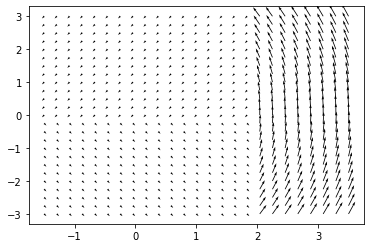

In [3]:
n_grid = 25
x0, x1 = torch.linspace(-1.5, 3.5, n_grid), torch.linspace(-3, 3, n_grid)
X0, X1 = torch.meshgrid(x0, x1); z = (X0.reshape(-1, 1), X1.reshape(-1, 1))
f0, f1 = NominalVectorField()(0, z)
F0, F1 = f0.reshape(n_grid, n_grid), f1.reshape(n_grid, n_grid)
plt.quiver(X0, X1, F0, F1, scale=150,)

#### Integrate Nominal System

Text(0.5, 1.0, 'State-Space Trajectories')

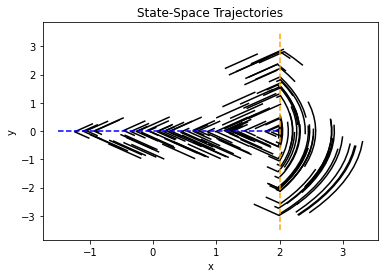

In [6]:
x0, y0 = sample_at_swichting_surf(n_sample=128, Δ=.5, x_lim=-1, y_lim=[-3, 3])
x = (x0, y0)
t = torch.linspace(0, .5, 10).to(x0)
sol0, sol1 = odeint(NominalVectorField().to(device), x, t, method='midpoint', atol=1e-7, rtol=1e-9)
sol0, sol1 = sol0.detach().cpu(), sol1.detach().cpu()

plt.plot(sol0[:,:,0], sol1[:,:,0], 'k');
plt.plot([-1.5, 2], [0, 0], '--b')
plt.plot([2, 2], [-3.5, 3.5], '--', c='orange')
plt.xlabel('x') ; plt.ylabel('y') ; plt.title('State-Space Trajectories')

### Learning Model

Let $g_\theta$ be a Neural Network $g_\theta:\mathbb R^2\rightarrow\mathbb R^3;x_t,y_t\mapsto g_\theta(x_t, y_t)$.
We propose the following model

$$
    (\dot x_t, \dot y_t) = \sum_i w_t^i f_i(x_t, y_t)
$$
where 
$$
    w^i_t \sim {\tt Categorical}\left({\tt SoftMax}(g)(x_t, y_t)\right)
$$
being $f_i, g$ neural netwroks.

In [8]:
# Here, we add an additional mode f4 (redundant) over the three of the system. This is to simulate the fact that in general situations we do not have 
# information on the number of real modes.

def one_hot(idx, n_classes=3):
    return torch.zeros(len(idx), n_classes).to(idx).scatter_(1, idx.unsqueeze(1), 1.)
    
class LearnedSystem(nn.Module):
    def __init__(self, g):
        super().__init__()
        self.g = g
        self.f1 = nn.Sequential(nn.Linear(2, 32), nn.Softplus(), nn.Linear(32, 32),  nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 2))
        self.f2 = nn.Sequential(nn.Linear(2, 32), nn.Softplus(), nn.Linear(32, 32),  nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 2))
        self.f3 = nn.Sequential(nn.Linear(2, 32), nn.Softplus(), nn.Linear(32, 32),  nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 2))
        self.f4 = nn.Sequential(nn.Linear(2, 32), nn.Softplus(), nn.Linear(32, 32),  nn.Softplus(), nn.Linear(32, 32), nn.Tanh(), nn.Linear(32, 2))
    
            
    def forward(self, t, z):
        x, y = z
        
        ### compute weights (NN)
        z = torch.cat([x, y], -1)
        w = nn.Softmax(1)(self.g(z))
        
        w1, w2, w3, w4 = w[:,:1], w[:, 1:2], w[:, 2:3], w[:, 3:4]
        
        ### compute individual VFs
        f1_ =  self.f1(z)
        f2_ =  self.f2(z)
        f3_ =  self.f3(z)
        f4_ =  self.f4(z)
        
        ### weighted sum
        dz = w1*f1_ + w2*f2_ + w3*f3_ + w4*f4_ #+ w5*f5_
        dx, dy = dz[:,:1], dz[:,1:]
        return (dx, dy)

### Sample some trajectories for training

In [12]:
g = nn.Sequential(
        nn.Linear(2, 64),
        nn.SiLU(),
        nn.Linear(64, 64),
        nn.Tanh(),
        nn.Linear(64, 4))
F = LearnedSystem(g).to(device)

loss_log = []

In [16]:
EPOCHS = 3000
SAVE_PLOTS = False

t = torch.linspace(0, 0.5, 10).to(device)
nominal_system = NominalVectorField()

opt_w = torch.optim.AdamW(F.g.parameters(), lr=3e-3)
opt_1 = torch.optim.AdamW(F.f1.parameters(), lr=3e-3)
opt_2 = torch.optim.AdamW(F.f2.parameters(), lr=3e-3)
opt_3 = torch.optim.AdamW(F.f3.parameters(), lr=3e-3)
opt_4 = torch.optim.AdamW(F.f4.parameters(), lr=3e-3)
opt_4 = torch.optim.Adam(F.f4.parameters(), lr=3e-3)

sched_w = StepLR(opt_w, step_size=300, gamma=0.1)
sched_1 = StepLR(opt_1, step_size=300, gamma=0.1)
sched_2 = StepLR(opt_2, step_size=300, gamma=0.1)
sched_3 = StepLR(opt_3, step_size=300, gamma=0.1)
sched_4 = StepLR(opt_4, step_size=300, gamma=0.1)

x0, y0 = x0.to(device), y0.to(device)
z0 = (x0, y0)
for epoch in range(EPOCHS):  
    # Sample initial conditions
    x0, y0 = sample_at_swichting_surf(n_sample=128, Δ=.5, x_lim=-1, y_lim=[-3, 3])
    z0 = (x0, y0)

    # Compute nominal traj
    sol_x, sol_y = odeint(nominal_system, z0, t.to(x0), method='midpoint')
    sol_x, sol_y = sol_x.detach().to(device), sol_y.detach().to(device)
    
    # Infer model
    xT, yT = odeint(F, (x0.to(device), y0.to(device)), t.to(y0.to(device)), method='midpoint')
    
    loss = loss_fn(sol_x, sol_y, xT, yT)
    
    loss.backward()
    opt_w.step()
    opt_1.step()
    opt_2.step()
    opt_3.step()
    opt_4.step()
    
    sched_w.step()
    sched_1.step()
    sched_2.step()
    sched_3.step()
    sched_4.step()
    
    opt_w.zero_grad()
    opt_1.zero_grad()
    opt_2.zero_grad()
    opt_3.zero_grad()
    opt_4.zero_grad()
    
    with torch.no_grad():
        loss_log.append(loss[None])
        print(f"epoch: {epoch}, loss={loss}", end="\r")

        if not epoch % 100 and SAVE_PLOTS:
            plt.figure()
            plt.plot(xT[:,::10,0].cpu(), yT[:,::10,0].cpu(), 'k');
            plt.plot([-1.5, 2], [0, 0], '--b');
            plt.plot([2, 2], [-3.5, 3.5], '--', c='orange');
            plt.xlim([-1.5, 3.5])
            plt.ylim([-3.5, 3.5])
            plt.xlabel('x') ; plt.ylabel('y') ; plt.title('Learned State-Space Trajectories')
            plt.savefig(f'swl_sm_{epoch}.jpg')
            plt.close('all')
            
            plot(F.g, epoch, device)

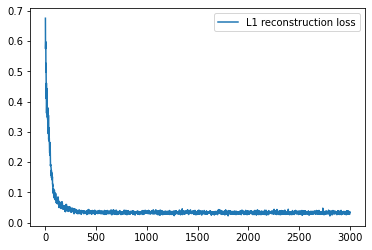

In [17]:
loss_log = torch.cat([l[None,:] for l in loss_log])
plt.plot(loss_log.cpu().detach())
plt.legend(['L1 reconstruction loss'])

Text(0.5, 1.0, 'Learned State-Space Trajectories')

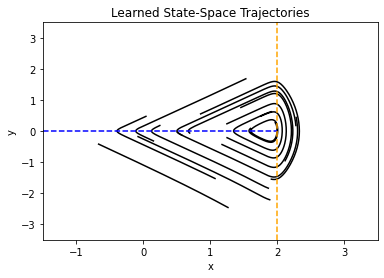

In [18]:
F = F.eval()
t = torch.linspace(0, 2, 200).to(device)
sol0, sol1 = odeint(F.to(device), (x0.to(device), y0.to(device)), t, method='midpoint', atol=1e-7, rtol=1e-9)
sol0, sol1 = sol0.detach().cpu(), sol1.detach().cpu()
plt.plot(sol0[:,::10,0], sol1[:,::10,0], 'k');
plt.plot([-1.5, 2], [0, 0], '--b');
plt.plot([2, 2], [-3.5, 3.5], '--', c='orange');
plt.xlim([-1.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.xlabel('x') ; plt.ylabel('y') ; plt.title('Learned State-Space Trajectories')

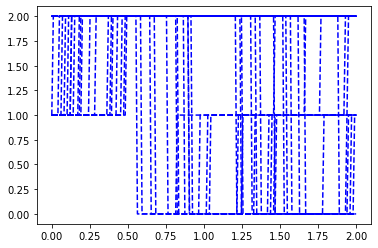

In [19]:
modes = label_trajectories(sol0, sol1)
for i in range(50):
    plt.plot(t, modes[:,i,:], '--b')

Text(0.5, 1.0, 'w_3')

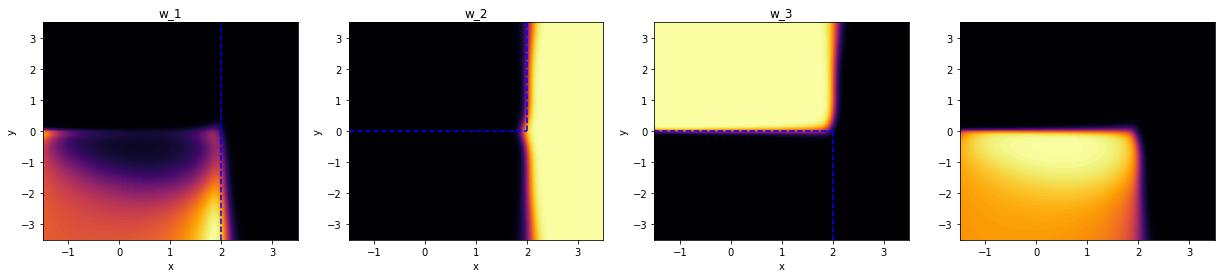

In [23]:
n_grid = 100
x, y = torch.linspace(-1.5, 3.5, n_grid), torch.linspace(-3.5, 3.5, n_grid)
X, Y = torch.meshgrid(x, y); z = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], -1).to(device)
W = nn.Softmax(-1)(g(z)).detach().cpu()
w_1, w_2, w_3, w_4, w_5 = W[:, :1], W[:, 1:2], W[:, 2:3], W[:, 3:4], W[:, 4:5]

fig, axs = plt.subplots(1, 4, figsize=(21, 4))
axs[0].contourf(X, Y, w_1.reshape(n_grid, n_grid), 100, cmap='inferno')
axs[1].contourf(X, Y, w_2.reshape(n_grid, n_grid), 100, cmap='inferno')
axs[2].contourf(X, Y, w_3.reshape(n_grid, n_grid), 100, cmap='inferno')
axs[3].contourf(X, Y, w_4.reshape(n_grid, n_grid), 100, cmap='inferno')

axs[0].plot([2, 2], [-3.5, 3.5], '--', c='blue');
axs[0].set_xlim([-1.5, 3.5]) ; axs[0].set_ylim([-3.5, 3.5])
axs[0].set_xlabel('x') ; axs[0].set_ylabel('y') ; axs[0].set_title('w_1')

axs[1].plot([2, 2], [0, 3.5], '--', c='blue');
axs[1].plot([-1.5, 2], [0, 0], '--b');
axs[1].set_xlim([-1.5, 3.5]) ; axs[1].set_ylim([-3.5, 3.5])
axs[1].set_xlabel('x') ; axs[1].set_ylabel('y') ; axs[1].set_title('w_2')

axs[2].plot([2, 2], [-3.5, 0], '--', c='blue');
axs[2].plot([-1.5, 2], [0, 0], '--b');
axs[2].set_xlim([-1.5, 3.5]) ; axs[2].set_ylim([-3.5, 3.5])
axs[2].set_xlabel('x') ; axs[2].set_ylabel('y') ; axs[2].set_title('w_3')

The model uses a mixture of 1st and 4th modes to approximate the dynamics (mode mixing). The true system only has three. This mixing phenomenon worsens in higher dimensions, or in learning models applied to data collected from systems with more modes.

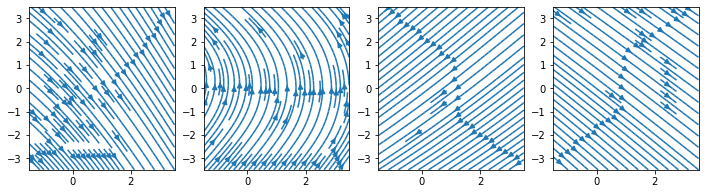

In [22]:
n_grid = 100
x, y = torch.linspace(-1.5, 3.5, n_grid), torch.linspace(-3.5, 3.5, n_grid)
X, Y = torch.meshgrid(x, y); z = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], -1).to(device)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
fs = [F.f1, F.f2, F.f3, F.f4]
for i in range(4):
    yy = fs[i](z).detach().cpu()
    axs[i].streamplot(X.T.numpy(), Y.T.numpy(), yy.reshape(n_grid, n_grid, 2)[:,:,0].T.numpy(), yy.reshape(n_grid, n_grid, 2)[:,:,1].T.numpy(), 1, cmap='inferno')